In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import multiprocessing

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')

from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'

In [2]:
def increaseIncDF_binSize(df,binSize):
    """This collapses consective bins in an incidence DF
    to reduce dimensions. This also means that some multiway
    interactions are now collapsed and those edges will be
    pruned"""
    result = []
    names = []
    for i in range(0,len(df) - binSize + 1,binSize):
        summed_value = df.loc[i:i+binSize-1,:].sum()
        summed_value[summed_value > 0] = 1
        names.append(f"Bin{i}:{i+binSize-1}")
        result.append(summed_value)
    result_df = pd.DataFrame(result,index = names)
    result_df = result_df.loc[:,result_df.sum() >= 2]
    return(result_df)

def dfToDict(df,result_dict):
    """Takes in an incidence DF and converts to 
    a dictionary of hyperedges"""
    for col in df.columns:
        twoWayRatio = float(col.split("_")[1])
        indices = df.index[df[col] == 1].tolist()
        key = '_'.join(indices)

        tmpList = result_dict.get(key, [])
        if tmpList:
            tmpList[0] += 1
            tmpList[1].append(twoWayRatio)
        else:
            tmpList = [1,[twoWayRatio]]
        result_dict[key] = tmpList
    return [result_dict]

class IncDFCreator:
    """Replacing this function: makeIncDF_fromChainDists"""
    def __init__(self, numProcesses, prim_cutoff, sec_cutoff, offDiagLim):
        self.numProcesses = numProcesses
        self.prim_cutoff = prim_cutoff
        self.sec_cutoff = sec_cutoff
        self.offDiagLim = offDiagLim

    def preprocessMat(self, chainMat):
        """Get upper triangular matrix and number of rows"""
        nrow = chainMat.shape[0]
        chainMat_triu = np.triu(chainMat, k=1)
        return chainMat_triu, nrow
    
    def assessMultiway(self, slice):
        """How many 2-way contacts fall below secondary cutoff"""
        total = np.count_nonzero(slice)
        passThresh = np.count_nonzero(slice[slice < self.sec_cutoff])
        ratio = passThresh / total
        return(ratio)
        
    def perRow(self, args):
        """Per row of upper tri matrix, get potential list of
        neighbors that fulfill distance criteria. Take iterative
        n choose k subsets of the matrix if the elements fall below 
        primary cutoff. If all elements fall 
        below the secondary distance cutoff needed to make it interact, then
        report that as a hyperedge"""
        chainMat_triu, row_ix = args
        columns_to_add = []
        ratioVec = []
        self.nrow = chainMat_triu.shape[0]
        vec = chainMat_triu[row_ix, row_ix + self.offDiagLim:]
        #condition1 = (0 < vec)
        condition2 = (vec < self.prim_cutoff)
        possNeighbors = [row_ix + self.offDiagLim + index for index in np.where(condition2)[0]]
        possNeighbors.insert(0, row_ix)
        if possNeighbors:
            for ix in range(2, len(possNeighbors)):
                for comb in combinations(possNeighbors, ix):
                    d = chainMat_triu[np.ix_(comb, comb)]
                    ratioUnderThresh = self.assessMultiway(d)
                    if ratioUnderThresh >= 0.5:
                        new_column = np.zeros(self.nrow)
                        new_column[list(comb)] = 1
                        columns_to_add.append(new_column)
                        ratioVec.append(ratioUnderThresh)
        if columns_to_add:
            return [columns_to_add,ratioVec]
        else:
            return None

    def mp(self, chainMat_triu, nrow):
        """Define multiprocessing pool"""
        pool = multiprocessing.Pool(self.numProcesses)
        argument_pairs = [(chainMat_triu, row_ix) for row_ix in range(nrow)]
        results = pool.map(self.perRow, argument_pairs)
        return results

    def makeIncDF_fromChainDists_mp(self, chainMat):
        """Run the dist matrix --> incidence DF in a parallelized
        fashion"""
        chainMat_triu, nrow = self.preprocessMat(chainMat)
        results = self.mp(chainMat_triu, nrow)
        filtered_results = [arr[0] for arr in results if arr is not None]
        ratioVec = flatten([vec[1] for vec in results if vec is not None])
        df = pd.DataFrame(np.concatenate(filtered_results)).T
        return [df,ratioVec]

    def makeIncDF_fromChainDists_single(self, chainMat):
        """Run the dist matrix --> incidence DF in a single-threaded
        fashion"""
        chainMat_triu, nrow = self.preprocessMat(chainMat)
        res = []
        rV = []
        for i in range(nrow):
            args = (chainMat_triu, i)
            row_result = self.perRow(args)
            if row_result is not None:
                res.append(row_result[0])
                rV.append(row_result[1])
        filtered_results = [arr for arr in res if arr is not None]
        df = pd.DataFrame(np.concatenate(filtered_results)).T
        ratioVec = flatten(rV)
        return [df, ratioVec]

In [3]:
numProcesses = 4
prim_cutoff = 500
sec_cutoff = 550
offDiagLim = 3

creator = IncDFCreator(numProcesses, prim_cutoff, sec_cutoff, offDiagLim)

In [4]:
exMat = np.loadtxt(f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_5292.txt')
# exChain = creator.makeIncDF_fromChainDists_mp(exMat)

In [5]:
A = creator.makeIncDF_fromChainDists_mp(exMat)
df = A[0]
ratios = A[1]


In [130]:
seventy = [index for index, value in enumerate(ratios) if value > 0.7]
len(seventy)

15672

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,66357,66358,66359,66360,66361,66362,66363,66364,66365,66366
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
df.index = ["Bin"+str(i) for i in range(500)]

In [168]:
inc_dict = {}
inc_dict = dfToDict(df,inc_dict)

In [7]:
bInc_by5 = increaseIncDF_binSize(df,5)

In [9]:
newCols = [str(bInc_by5.columns[i])+"_"+str(round(ratios[i],2)) 
           for i in range(bInc_by5.shape[1])]
bInc_by5.columns = newCols

In [10]:
bInc_dict = {}
bInc_dict = dfToDict(bInc_by5,bInc_dict)[0]

In [22]:
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/'
file_path = f'{outDir}binConcatInc_3_500_550_1.pkl'

import pickle
with open(file_path,'wb') as pklFile:
    pickle.dump(bInc_dict,pklFile)

In [170]:
roi = 'Bin0:4_Bin5:9_Bin10:14_Bin30:34_Bin370:374'
ids = roi.split("_")

### this is convoluted but it works
sevenWay1 = np.where(bInc_by5.sum() == 5)[0].tolist()
print(len(sevenWay1))
actualColname = [bInc_by5.columns[s] for s in sevenWay1]
subset_binnedDF = bInc_by5[actualColname]
print(subset_binnedDF.shape)
subset_binnedDF2 = subset_binnedDF.loc[ids]
print(subset_binnedDF2.shape)
sevenWay2 = np.where(subset_binnedDF2.sum() == 5)[0].tolist()
print(len(sevenWay2))
actualColname2 = [subset_binnedDF2.columns[s] for s in sevenWay2]
subset_binnedDF2[actualColname2]

15206
(100, 15206)
(5, 15206)
26


,121,122,123,124,127,128,129,130,164,165,...,173,174,175,176,187,188,189,190,191,192
Bin0:4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin5:9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin10:14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin30:34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin370:374,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [171]:
roi_iDF = df[actualColname2]
roi_iDF.loc[~(roi_iDF==0).all(axis=1)]

,121,122,123,124,127,128,129,130,164,165,...,173,174,175,176,187,188,189,190,191,192
Bin3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bin10,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
Bin11,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Bin33,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
Bin34,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Bin373,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Bin374,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [95]:
def makeHiC_fromInc(incDF):
    ## Convert incidence matrix to 2d hiC matrix
    nrow = incDF.shape[0]
    binIDs = list(incDF.index)
    if isinstance(binIDs[0],str) and ":" in binIDs[0]:
        sorted_binIDs = sorted(binIDs, key=sort_key)
    else:
        sorted_binIDs = binIDs.sort()
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=sorted_binIDs, 
                      columns=sorted_binIDs)
    for read in incDF.columns:
        if isinstance(read,str) and ":" in read:
            support = int(read.split(":")[1])
        else:
            support = 1
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += support
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += support
            df.loc[c[1]][c[0]] += support
    return(df)

In [24]:
hic_mat = makeHiC_fromInc(df)

In [105]:
def multiresolutionProjMat(df, ratios, report):
    """Given an incidence DF and information about how many (ratio)
    2-way interactions of a multiway interactions are present in the data,
    calculate projection matrices at each resolution"""
    projMat_dict = {}
    for cutoff in [0.9,1]: #0.5,0.75,
        print(f"Making projection matrix for 2-way cutoff = {cutoff}")
        subset = [index for index, value in enumerate(ratios) if value >= cutoff]
        report.append(len(subset))
        subset_df = df.iloc[:,subset]
        hic_subset = makeHiC_fromInc(subset_df)
        projMat_dict[cutoff] = hic_subset
    return [projMat_dict,report]

In [106]:
report = []
pm_dict = multiresolutionProjMat(df,ratios,report)

Making projection matrix for 2-way cutoff = 0.9
Making projection matrix for 2-way cutoff = 1


(500, 500)


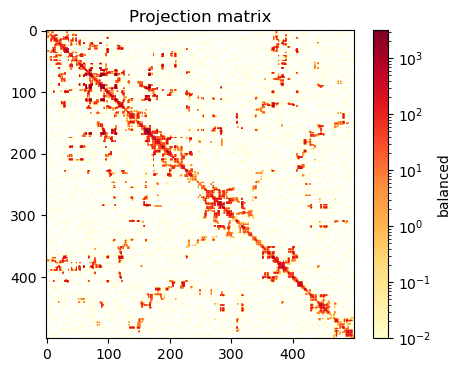

In [28]:
print(hic_mat.shape)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(hic_mat, cmap="YlOrRd",norm = LogNorm(vmax=10**3.5, vmin = 0.01)) #
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

(500, 500)


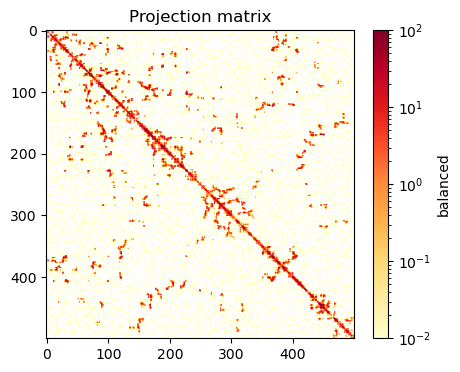

In [110]:
print(hic_subset.shape)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(pm_dict[0][0.9], cmap="YlOrRd",norm = LogNorm(vmax=10**2, vmin = 0.01)) #
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

### Comparing cutoffs and ratios to select best + fastest one for running

In [ ]:
fileNames = ['binConcatInc_3_500_550_3.pkl','binConcatInc_1_500_550_3.pkl',
             'binConcatInc_3_500_550_4.pkl','binConcatInc_3_500_600_4.pkl','binConcatInc_3_500_650_4.pkl',
            'binConcatInc_3_500_550_6.pkl','binConcatInc_3_500_750_6.pkl']

#### extending dicts

In [115]:
import os.path
outDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.processChainsOutput_10k_500_sample1/'

newDict = {}
for i in [1,2]:
    file_path = f'{outDir}binConcatInc_3_500_550_1.pkl'
    if os.path.isfile(file_path):
        with open(file_path,'rb') as f:
            bIncDict = pickle.load(f)


In [14]:
a1 = {'Bin0:4_Bin5:9': [4, [1.0, 1.0, 1.0, 0.67]],
 'Bin0:4_Bin370:374': [4, [1.0, 1.0, 1.0, 0.67]],
 'Bin0:4_Bin5:9_Bin370:374': [5, [1.0, 0.67, 1.0, 1.0, 0.5]],
 'Bin0:4_Bin10:14': [3, [1.0, 1.0, 0.67]],
 'Bin0:4_Bin30:34': [3, [1.0, 1.0, 1.0]],
 'Bin5:9_Bin10:14': [4, [1.0, 1.0, 0.67, 0.83]]}

a2 = {'Bin95:99_Bin185:189': [3, [0.67, 0.64, 0.5]],
 'Bin95:99_Bin200:204': [4, [0.5, 1.0, 0.6, 0.8]],
 'Bin0:4_Bin5:9_Bin370:374': [5, [1.0, 0.67, 1.0, 1.0, 0.5]],
 'Bin185:189_Bin205:209': [3, [1.0, 0.6, 0.57]],
 'Bin185:189_Bin210:214': [6, [0.7, 0.53, 0.61, 0.57, 1.0, 0.6]],
 'Bin190:194_Bin205:209': [5, [1.0, 0.6, 0.53, 0.67, 0.57]]}


In [15]:
resultDict = {}

def appendSingleBIncDict(chainDict,resultDict):
    """Takes in a binned inc dictionary which contains the
    read, number of times it occurred in a chain, and the
    % two-way support for that multiway read. It combines 
    each element, i.e., 3 elements per key to create a
    a bigger chunked dict."""
    for key, value in chainDict.items():
        tmpList = resultDict.get(key,[])
        if tmpList:
            tmpList[0] += value[0]
            tmpList[1] += 1
            tmpList[2].append(value[1])
        else:
            tmpList = [value[0],1,value[1]]
        resultDict[key] = tmpList
    return(resultDict)

for chainDict in [a1,a2]:
    resultDict = appendSingleBIncDict(chainDict,resultDict)

print(resultDict)

{'Bin0:4_Bin5:9': [4, 1, [1.0, 1.0, 1.0, 0.67]], 'Bin0:4_Bin370:374': [4, 1, [1.0, 1.0, 1.0, 0.67]], 'Bin0:4_Bin5:9_Bin370:374': [10, 2, [1.0, 0.67, 1.0, 1.0, 0.5, [1.0, 0.67, 1.0, 1.0, 0.5]]], 'Bin0:4_Bin10:14': [3, 1, [1.0, 1.0, 0.67]], 'Bin0:4_Bin30:34': [3, 1, [1.0, 1.0, 1.0]], 'Bin5:9_Bin10:14': [4, 1, [1.0, 1.0, 0.67, 0.83]], 'Bin95:99_Bin185:189': [3, 1, [0.67, 0.64, 0.5]], 'Bin95:99_Bin200:204': [4, 1, [0.5, 1.0, 0.6, 0.8]], 'Bin185:189_Bin205:209': [3, 1, [1.0, 0.6, 0.57]], 'Bin185:189_Bin210:214': [6, 1, [0.7, 0.53, 0.61, 0.57, 1.0, 0.6]], 'Bin190:194_Bin205:209': [5, 1, [1.0, 0.6, 0.53, 0.67, 0.57]]}


In [20]:
import os.path
import pickle

dictDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/v2.makeCombinedHypergraphDicts/'

file_path = f'{dictDir}hyperEdges_3_500_550_final_chains.pkl'
if os.path.isfile(file_path):
    with open(file_path,'rb') as f:
        finalDict = pickle.load(f)

In [41]:
from statistics import median

hpKeys = finalDict.keys()
totalReadSupport = [v[0] for v in finalDict.values()]
totalChainSupport = [v[1] for v in finalDict.values()]
medianReadConfPerChain = [[median(rat) for rat in flatten(v[2])] for v in finalDict.values()]
readCards = [v[3] for v in finalDict.values()]

In [24]:
from statistics import mean
from statistics import median

a = [1.0, 0.67, 0.67, 0.5, 0.52, 0.57]
print(mean(a))
print(median(a))

0.655
0.62


In [ ]:
## Make multiple incDFs ? Or somehow save the ratio in a vector
## Make binned DF first
## Then dict
## Then extend and combine